In [20]:
## 학습 코드
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import time
import os
import copy
import random

In [23]:
batch_size  = 64
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = 'resnetTest/can_data/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
can_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
print('images :', len(can_dataset))
targets = can_dataset.targets

## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_idx, tmp_idx = train_test_split(list(range(len(can_dataset))), test_size=0.2, 
                                       random_state=random_seed)
datasets = {}
datasets['train'] = Subset(can_dataset, train_idx)
tmp_dataset       = Subset(can_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, 
                                     random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

print('train : %d / validation : %d / test : %d' % (len(datasets['train']), len(datasets['valid']), len(datasets['test'])))

## data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

images : 11361
train : 9088 / validation : 1136 / test : 1137
batch_size : 64,  tvt : 142 / 18 / 18


classes : 48


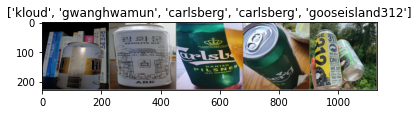

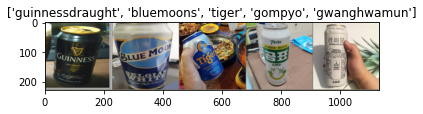

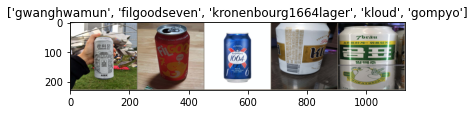

In [24]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    '0': "asahi",      
    '1': "kronenbourg1664blanc",  
    '2': "carlsberg",
    '3': "cassfresh",
    '4': "casslight",
    '5': "filitebarley",
    '6': "filitefresh",
    '7': "guinnessdraught",
    '8': "heineken",
    '9': "hoegaarden",
    '10': "hophouse13",
    '11': "kloud",
    '12': "kozeldark",
    '13': "pilsnerurquell",
    '14': "fitz",
    '15': "sapporo",
    '16': "stellaartois",
    '17': "terra",
    '18': "tiger",
    '19': "tsingtao",
    '20': "gompyo",
    '21': "malpyo",
    '22': "grimbergenblanche",
    '23': "macarthur",
    '24': "budweiser",
    '25': "becks",
    '26': "bluemoons",
    '27': "sunhanipa",
    '28': "jejuwitale",
    '29': "jejupellongale",
    '30': "kronenbourg1664lager",
    '31': "klouddraft",
    '32': "filgoodseven",
    '33': "filgoodoriginal",
    '34': "hiteextracold",
    '35': "heungcheongmangcheong",
    '36': "somersby",
    '37': "desperadosoriginal",
    '38': "paulanerweissbier",
    '39': "guinnessoriginal",
    '40': "filiteweizen",
    '41': "heinekendark",
    '42': "leffebrune",
    '43': "peroni",
    '44': "gooseisland312",
    '45': "tigerradlergrapefruit",
    '46': "gwanghwamun",
    '47': "seongsanilchulbong"
}

print('classes : %d' % len(class_names))

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
            
        epoch_end = time.time() - epoch_start
        print('Epoch elapsed time : {:.0f}m {:.0f}s'.format(epoch_end // 60, epoch_end % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'resnet34_48class.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.54 Acc: 51.4
valid Loss: 1.12 Acc: 87.3
==> best model saved - 0 / 87.3
Epoch elapsed time : 3m 57s
Epoch 1/29
----------
train Loss: 0.65 Acc: 95.1
valid Loss: 0.38 Acc: 97.1
==> best model saved - 1 / 97.1
Epoch elapsed time : 4m 0s
Epoch 2/29
----------
train Loss: 0.25 Acc: 98.6
valid Loss: 0.21 Acc: 98.4
==> best model saved - 2 / 98.4
Epoch elapsed time : 3m 54s
Epoch 3/29
----------
train Loss: 0.14 Acc: 99.3
valid Loss: 0.15 Acc: 98.8
==> best model saved - 3 / 98.8
Epoch elapsed time : 3m 58s
Epoch 4/29
----------
train Loss: 0.09 Acc: 99.6
valid Loss: 0.11 Acc: 99.0
==> best model saved - 4 / 99.0
Epoch elapsed time : 4m 2s
Epoch 5/29
----------
train Loss: 0.07 Acc: 99.7
valid Loss: 0.10 Acc: 99.1
==> best model saved - 5 / 99.1
Epoch elapsed time : 3m 60s
Epoch 6/29
----------
train Loss: 0.05 Acc: 99.8
valid Loss: 0.08 Acc: 98.9
Epoch elapsed time : 3m 55s
Epoch 7/29
----------
train Loss: 0.04 Acc: 99.9
valid Loss: 0.08 Acc: 99.1
Epoch 

best model : 5 - 99 / 0.1


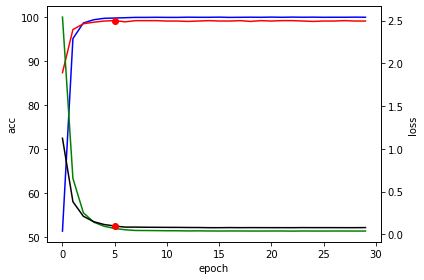

In [17]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

test done : loss/acc : 0.08 / 99.1
64
64


<ipython-input-21-e7bfe7ca3915>:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, 1)


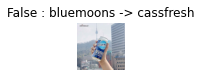

64


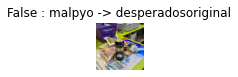

64
64
64
64


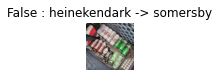

64
64


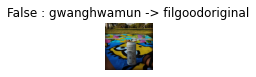

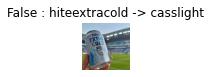

64
64
64
64
64


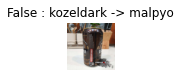

64


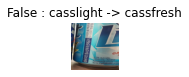

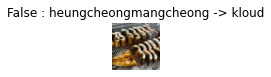

64
64


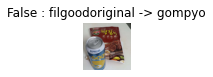

49


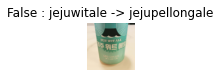

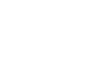

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('resnet18_48class.pt'))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

def test_and_visualize_model(model, phase = 'test', num_images=5):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            
            print(len(inputs))
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(0, len(inputs)):
                ax = plt.subplot(4, 4, 1)
                ax.axis('off')
                
                test_correct = class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())]
                
                if not test_correct:
                    ax.set_title('%s : %s -> %s'%(str(test_correct),
                        class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                    imshow(inputs.cpu().data[j])
#             if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
## TEST!
test_and_visualize_model(model, phase = 'test', num_images=64)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = models.resnet101(pretrained=True)

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load('weights/resnet101.pt'))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

preprocess = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

def test_and_visualize_model(model, phase = 'test', num_images=10):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        crop_path = 'forServiceTest/output'
        crop_list = os.listdir(crop_path)

        for crop in crop_list:
            img_can = Image.open('%s/%s' % (crop_path, crop)).convert('RGB')
            img_can = preprocess(img_can)
            inputs = torch.unsqueeze(img_can, 0)
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(crop, str(preds.cpu().numpy()))
            print(torch.nn.functional.softmax(outputs, dim=1)[0] * 100)
#         for i, (inputs, labels) in enumerate(dataloaders[phase]):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             loss = criterion(outputs, labels)  # batch의 평균 loss 출력

#             running_loss    += loss.item() * inputs.size(0)
#             running_corrects+= torch.sum(preds == labels.data)
#             num_cnt += inputs.size(0)  # batch size

#     #         if i == 2: break

#         test_loss = running_loss / num_cnt
#         test_acc  = running_corrects.double() / num_cnt       
#         print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders[phase]):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)        

#             # 예시 그림 plot
#             for j in range(1, num_images+1):
#                 ax = plt.subplot(num_images//2, 2, j)
#                 ax.axis('off')
#                 ax.set_title('%s : %s -> %s'%(
#                     'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
#                     class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
#                 imshow(inputs.cpu().data[j])          
#             if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
## TEST!
test_and_visualize_model(model, phase = 'test')